# Steam Data Exploration: Profitable App Profiles

*This forms part of a larger series of posts for my [blog](http://nik-davis.github.io) on downloading, processing and analysing data from the steam store. [See all posts here](http://nik-davis.github.io/tag/steam).*

In [4]:
# view software version information

# http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, pandas, matplotlib, seaborn, sklearn

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.5.0
OS Windows 10 10.0.18362 SP0
numpy 1.16.3
pandas 0.24.2
matplotlib 3.1.0
seaborn 0.9.0
sklearn 0.21.2
Wed Jun 05 18:28:00 2019 GMT Summer Time

In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Ideas
- when will valve release half life 3
- best publishers/developers (or best and worst releases)
- older is better/ best year for games
- Is single-player dying? single vs multiplayer
- description columns - analyse sentiment/emotion

### Issues
- prediction - low correlations so difficult

In [2]:
# standard library imports
from ast import literal_eval
import itertools
import time
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_selection import RFECV

# customisations
pd.set_option("max_columns", 100)

In [ ]:
import holoviews as hv
hv.__version__

In [ ]:
hv.extension('bokeh', 'matplotlib')

In [ ]:
# check a file
import os
if not os.path.isfile('../data/steamspy_clean.csv'):
    print('file not found')

## Import data and preprocess for exploration

In [7]:
def remove_non_english(df):
    df = df[df['english'] == 1].copy()
    
    # doesn't contain 3 or more non-ascii characters
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    df = df.drop('english', axis=1)
    
    return df


def calc_rating(row):

    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg

    average = pos / total_reviews

    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    cat_cols = [
#         'Local Multi-Player',
#         'MMO',
#         'Mods',
        'Multi-player',
#         'Online Co-op',
#         'Online Multi-Player',
        'Single-player'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    gen_cols = [
#         'Accounting',
        'Action',
        'Adventure',
#         'Animation & Modeling',
#         'Audio Production',
        'Casual',
#         'Design & Illustration',
#         'Documentary',
#         'Early Access',
#         'Education',
#         'Free to Play',
#         'Game Development',
#         'Gore',
        'Indie',
        'Massively Multiplayer',
#         'Nudity',
#         'Photo Editing',
        'RPG',
        'Racing',
#         'Sexual Content',
        'Simulation',
#         'Software Training',
        'Sports',
        'Strategy'
#         'Tutorial',
#         'Utilities',
#         'Video Production',
#         'Violent',
#         'Web Publishing'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0]
        
    tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['tags'].apply(lambda x: x.split(';')[0] if ';' in x else x)
    
    # display(cat_cols, gen_cols, tag_cols)
    df = df.drop(['categories', 'genres', 'steamspy_tags'], axis=1)
    
    return df


def process_year(df):
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    return df


def process_dev_pub(df):
    for col in ['developer', 'publisher']:
        col_name = col+'_rating'
        ratings = df.groupby(col).mean()['rating']
        df[col_name] = df[col].apply(lambda x: ratings[x] if x in ratings else 0)
        
        release_counts =  df.groupby(col).count()['steam_appid']
        df[col+'_releases'] = df[col].apply(lambda x: release_counts[x] if x in release_counts else 0)
        
    return df
    
def process_revenue(df):
    df['est_revenue'] = df['owners'] * df['price']
    return df


def process_price(df):
    cut_points = [-1, 0, 4, 10, 30, 50, 1000]
    label_names = ['free', 'very cheap', 'cheap', 'moderate', 'expensive', 'very expensive']
    
    df['price_categories'] = pd.cut(df['price'], cut_points, labels=label_names)
    
    return df


def pre_process():
    df = pd.read_csv('../data/steam_clean.csv')
    
    # english only
    df = remove_non_english(df)
    
    # windows only
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    df['owners'] = df['owners'].str.split('-').apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)
    # df['owners'] = df['owners'].str.replace('[+,]', '').astype(int)
    
    # calculate ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['ratings_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['weighted_rating'] = df.apply(calc_rating, axis=1)
    # df = df.drop(['positive', 'negative'], axis=1)
    
    df = df.rename(columns={'average_forever': 'average_playtime', 'median_forever': 'median_playtime'})
    
    df = process_year(df)
    # df = process_dev_pub(df)

    df = process_revenue(df)
    df = process_price(df)
    
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()

print(data.isnull().sum().value_counts())
data.head()

0    31
dtype: int64


,appid,name,release_date,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,ratings_ratio,weighted_rating,release_year,est_revenue,price_categories,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,0,124534,3339,17612,317,15000000,7.19,127873,0.973888,95.975678,2000,107850000.0,cheap,1,0,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,0,3318,633,277,62,7500000,3.99,3951,0.839787,80.508259,1999,29925000.0,very cheap,1,0,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,0,3416,398,187,34,7500000,3.99,3814,0.895648,85.823915,2003,29925000.0,very cheap,1,0,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,0,1273,267,258,184,7500000,3.99,1540,0.826623,78.126542,2001,29925000.0,very cheap,1,0,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,0,5250,288,624,415,7500000,3.99,5538,0.947996,91.260480,1999,29925000.0,very cheap,1,1,1,0,0,0,0,0,0,0,0,0


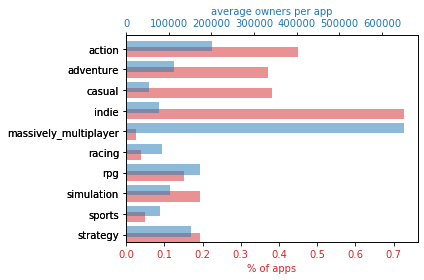

In [74]:
# percentage of apps in each genre
genre_cols = data.columns[-10:]

total_owners_per_genre = data[genre_cols].multiply(data['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / data[genre_cols].sum()

fig, ax1 = plt.subplots()

color = 'tab:red'
data[genre_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.5, position=.8)
# ax1.set_ylabel('genre')
ax1.set_xlabel('% of apps', color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:blue'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=.5, position=.2, label='1')
ax2.set_xlabel('average owners per app', color=color)
ax2.tick_params(axis='x', labelcolor=color)

plt.tight_layout()
plt.show()

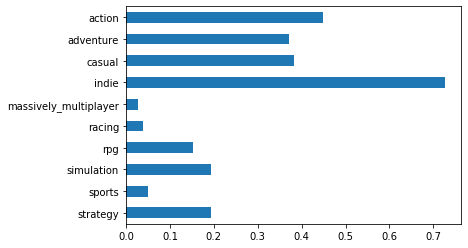

In [28]:
# percentage of apps in each genre
genre_cols = data.columns[-10:]

data[genre_cols].mean().sort_index(ascending=False).plot.barh();

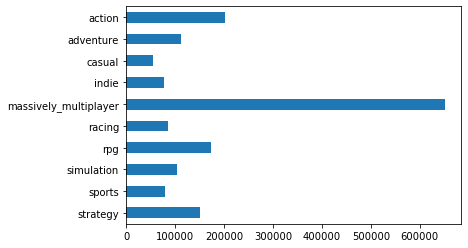

In [9]:
total_owners_per_genre = data[genre_cols].multiply(data['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / data[genre_cols].sum()

average_owners_per_genre.sort_index(ascending=False).plot.barh();

In [5]:
data[data['massively_multiplayer'] == 1].sort_values(by='owners', ascending=False).head(10)

,name,steam_appid,required_age,achievements,release_date,price,developer,publisher,positive,negative,owners,average_playtime,median_playtime,num_ratings,rating,weighted_rating,release_year,est_revenue,price_categories,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
12836,PLAYERUNKNOWN'S BATTLEGROUNDS,578080,0,37,2017-12-21,26.99,PUBG Corporation,PUBG Corporation,496184,487076,75000000,22938,12434,983260,0.504632,50.066901,2017,2.024250e+09,moderate,1,0,1,1,0,0,1,0,0,0,0,0
2951,Warface,291480,16,30,2014-07-01,0.00,My.com,My.com,32751,14409,15000000,949,104,47160,0.694466,68.085960,2014,0.000000e+00,free,1,0,1,0,0,0,1,0,0,0,0,0
3251,Robocraft,301520,0,43,2017-08-24,0.00,Freejam,Freejam,80360,30987,15000000,1369,211,111347,0.721708,71.079018,2017,0.000000e+00,free,1,0,1,0,0,1,1,1,0,1,0,0
1772,Path of Exile,238960,0,120,2013-10-23,0.00,Grinding Gear Games,Grinding Gear Games,71593,6117,15000000,5263,492,77710,0.921284,90.575389,2013,0.000000e+00,free,1,1,1,1,0,1,1,1,0,0,0,0
1727,War Thunder,236390,0,46,2013-08-15,0.00,Gaijin Entertainment,Gaijin Entertainment,83852,22166,15000000,4200,297,106018,0.790922,77.877967,2013,0.000000e+00,free,0,1,1,0,0,0,1,0,0,1,0,0
7809,Z1 Battle Royale,433850,0,0,2018-02-28,0.00,NantG,Daybreak Game Company,111434,91664,15000000,3142,162,203098,0.548671,54.174476,2018,0.000000e+00,free,1,0,1,1,0,0,1,0,0,0,0,0
1607,Heroes & Generals,227940,0,0,2016-10-18,0.00,RETO MOTO,RETO MOTO,65856,34416,15000000,1752,76,100272,0.656774,64.651991,2016,0.000000e+00,free,1,0,1,0,0,1,1,0,0,0,0,0
11994,Infestation: The New Z,555570,0,63,2016-11-22,0.00,Fredaikis AB,Fredaikis AB,13726,14201,7500000,376,73,27927,0.491496,48.022116,2016,0.000000e+00,free,0,0,1,0,0,1,1,1,0,0,0,0
3340,Trove,304050,0,16,2015-07-09,0.00,Trion Worlds,Trion Worlds,47897,13708,7500000,2602,184,61605,0.777486,76.343023,2015,0.000000e+00,free,0,0,1,1,1,0,1,1,0,0,0,0
2502,Counter-Strike Nexon: Zombies,273110,0,65,2014-10-07,0.00,"Valve Corporation, Nexon Korea Corporation",Nexon Korea Corporation,22130,12127,7500000,4047,112,34257,0.645999,63.206449,2014,0.000000e+00,free,1,1,1,0,1,0,1,0,0,0,0,0


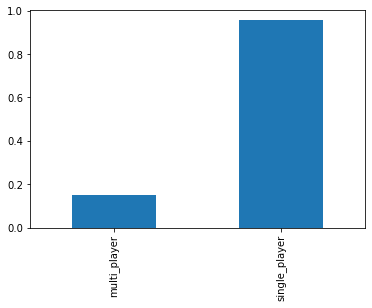

In [82]:
# percentage of apps in each category
cat_cols = ['multi_player', 'single_player']

data[(data['multi_player'] == 1) & (data['single_player'] == 1)].shape[0]
data[cat_cols].mean().plot.bar()

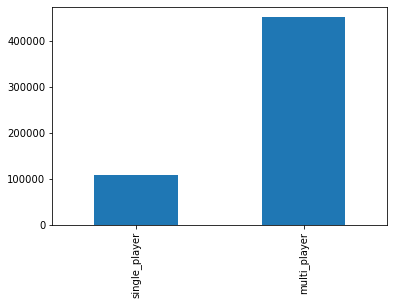

In [7]:
total_owners_per_cat = data[cat_cols].multiply(data['owners'], axis='index').sum()
average_owners_per_cat = total_owners_per_cat / data[cat_cols].sum()

average_owners_per_cat.sort_values().plot.bar()

,average_playtime,owners,n_releases,weighted_rating
developer,,,,
Valve,2871.583333,403500000,24,86.229421
Bethesda Game Studios,2001.800000,37050000,10,80.565951
Digital Extremes,2012.000000,36575000,3,83.445259
Facepunch Studios,5443.500000,22520000,4,73.472961
Ubisoft Montreal,1027.368421,20270000,19,74.314250
Bohemia Interactive,2410.866667,19105000,15,60.984001
Gearbox Software,378.571429,17700000,7,77.642837
Rockstar North,2486.500000,16850000,4,72.952430
Relic Entertainment,556.625000,16500000,8,87.991890


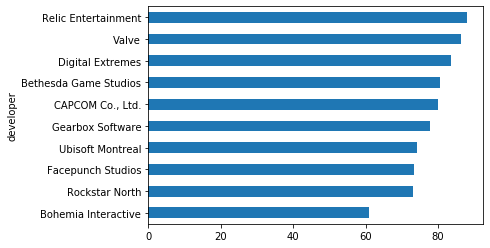

In [8]:
# top developers
dev_pv = data.pivot_table(index='developer', values=['steam_appid', 'owners', 'average_playtime', 'weighted_rating'],
                 aggfunc={'steam_appid': len, 
                          'owners': 'sum',
                          'average_playtime': 'mean',
                          'weighted_rating': 'mean'
                         }).rename({'steam_appid': 'n_releases'}, axis=1).sort_values('owners', ascending=False)

top_devs_pv = dev_pv[dev_pv['n_releases'] > 1].head(10)

display(top_devs_pv)
top_devs_pv['weighted_rating'].sort_values().plot.barh();

,average_playtime,owners,rating,n_releases,weighted_rating
publisher,,,,,
Valve,3743.535714,508500000,0.891063,28,86.721731
Ubisoft,956.459459,80835000,0.750815,111,70.397394
Bethesda Softworks,1303.558824,66535000,0.801995,34,77.520152
SEGA,766.012821,53245000,0.800676,78,73.608514
Square Enix,1314.979167,48305000,0.738177,96,69.041601
Electronic Arts,648.937500,41585000,0.816791,32,77.736716
Paradox Interactive,925.218182,41265000,0.735170,55,68.787463
Rockstar Games,980.333333,38360000,0.812426,15,77.653614
2K,431.195652,33280000,0.682882,46,62.705651


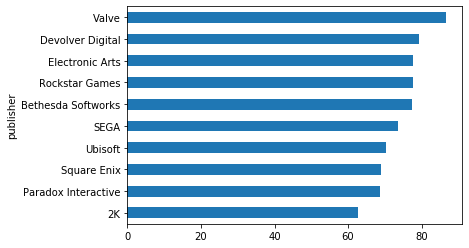

In [9]:
# top publishers
pub_pv = data.pivot_table(index='publisher', values=['steam_appid', 'owners', 'average_playtime', 'weighted_rating', 'rating'],
                 aggfunc={'steam_appid': len, 
                          'owners': 'sum',
                          'average_playtime': 'mean',
                          'weighted_rating': 'mean',
                          'rating': 'mean'
                         }).rename({'steam_appid': 'n_releases'}, axis=1).sort_values('owners', ascending=False)

top_pubs_pv = pub_pv[pub_pv['n_releases'] > 1].head(10)

display(top_pubs_pv)
top_pubs_pv['weighted_rating'].sort_values().plot.barh();

0.7133588514488597
58.74868722415526


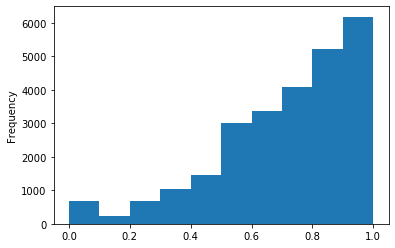

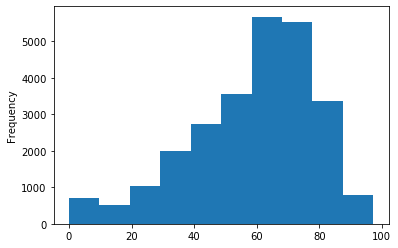

In [10]:
# overall ratings
print(data['rating'].mean())
print(data['weighted_rating'].mean())

data['rating'].plot.hist()
plt.show()

data['weighted_rating'].plot.hist();

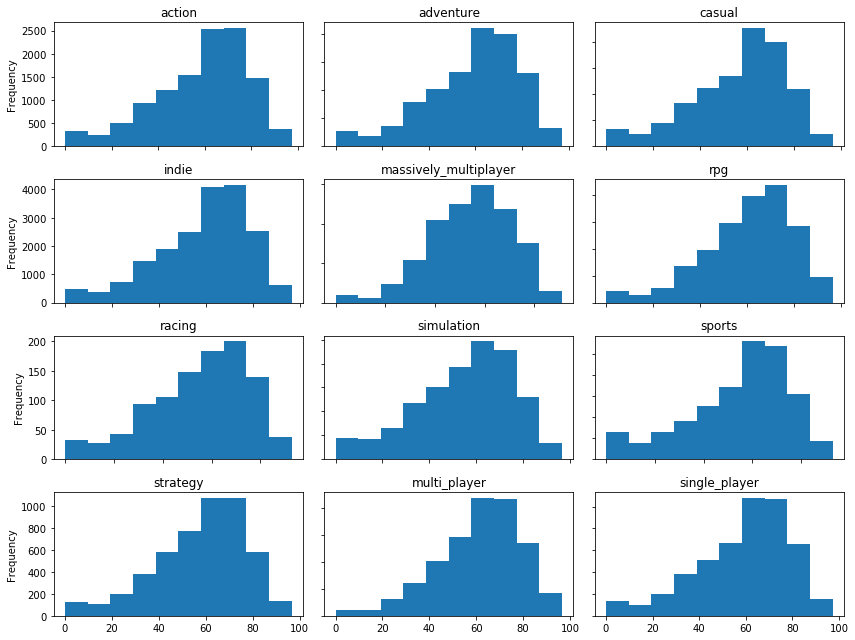

In [95]:
# (data[genre_cols].multiply(data['weighted_rating'], axis=0).sum() / data[genre_cols].sum()).plot.bar()

cols = list(genre_cols) + cat_cols

# ratings distribution by genre - need to create fig array
fig = plt.figure(figsize=(12, 9))

for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    
    col = cols[i]
    df = data.loc[data[col] == 1, [col, 'weighted_rating']]
    
    (df[col] * df['weighted_rating']).plot.hist(ax=ax, sharey=True, sharex=True, bins=10)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [107]:
# hence  means are different
import scipy.stats as stats

# won't work
# genre_ratings_data = [data.loc[data[genre] == 1, 'weighted_rating'] for i, genre in enumerate(genre_cols)]
# t1 = data[data['action'] == 1]['weighted_rating'].head(5), data[data['adventure'] == 1]['weighted_rating'].head(5)
# t2 = [data[data[g] == 1]['weighted_rating'].head(5) for i, g in enumerate(['action', 'adventure'])]

# print(tuple(t1))
# print(tuple(t2))

# type(t2)

f = stats.f_oneway(
    data[data['action'] == 1]['weighted_rating'],
    data[data['adventure'] == 1]['weighted_rating'],
    data[data['casual'] == 1]['weighted_rating'],
    data[data['indie'] == 1]['weighted_rating'],
    data[data['massively_multiplayer'] == 1]['weighted_rating'],
    data[data['rpg'] == 1]['weighted_rating'],
    data[data['racing'] == 1]['weighted_rating'],
    data[data['simulation'] == 1]['weighted_rating'],
    data[data['sports'] == 1]['weighted_rating'],
    data[data['strategy'] == 1]['weighted_rating']
)

f

F_onewayResult(statistic=41.40545266050743, pvalue=1.5299376211088596e-74)

In [166]:
# import holoviews as hv
# from holoviews import opts
# hv.extension('plotly')
# import plotly

In [169]:
# graph_data = [data[data[genre] == 1]['weighted_rating'] for genre in genre_cols]
# graph_data = [data.loc[data[g] == 1, 'weighted_rating'] for g in ['action', 'adventure']]


# action = data.loc[data['action'] == 1, 'weighted_rating']
# adventure = data.loc[data['adventure'] == 1, 'weighted_rating']

# layout = {
#     'shapes': [{
#         'type': 'line',
#         'x0': -.5,
#         'y0': data['weighted_rating'].mean(),
#         'x1': 10,
#         'y1': data['weighted_rating'].mean(),
#         'line': {'dash': 'dashdot'}
#     }]
# }

# graph_data = [{
#     'y': data.loc[data[g] == 1, 'weighted_rating'],
#     'type': 'violin',
#     'name': g,
#     'showlegend':False
# } for g in list(genre_cols)]

# plotly.offline.iplot({'data': graph_data, 'layout': layout})
# graph_data = [data.loc[data['action'] == 1, 'weighted_rating'], data.loc[data['adventure'] == 1, 'weighted_rating']]
# hv.Violin(graph_data)

[Text(0, 0, 'action'),
 Text(0, 0, 'adventure'),
 Text(0, 0, 'casual'),
 Text(0, 0, 'indie'),
 Text(0, 0, 'massively_multiplayer'),
 Text(0, 0, 'rpg'),
 Text(0, 0, 'racing'),
 Text(0, 0, 'simulation'),
 Text(0, 0, 'sports'),
 Text(0, 0, 'strategy')]

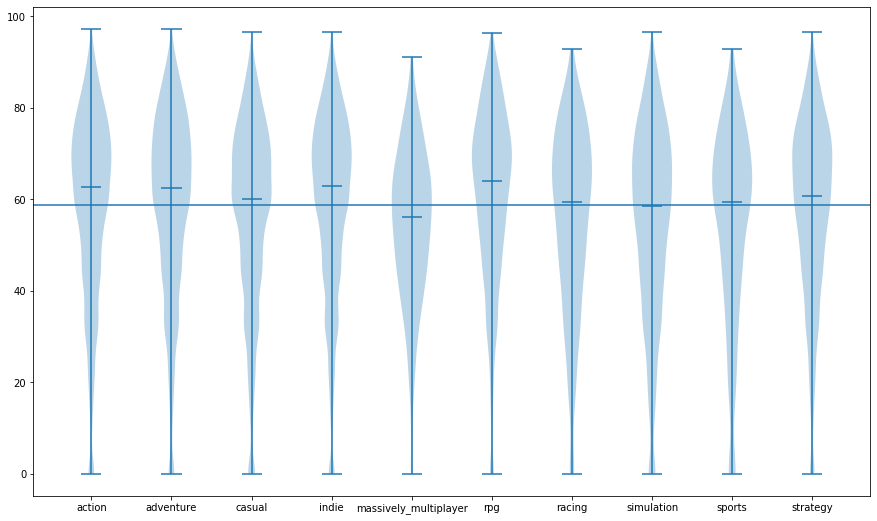

In [165]:
ac = data.loc[data['action'] == 1, 'weighted_rating']
ad = data.loc[data['adventure'] == 1, 'weighted_rating']

fig, ax = plt.subplots(figsize=(15,9))

ax.violinplot([data.loc[data[g] == 1, 'weighted_rating'].values for g in genre_cols],
               showmeans=False,
               showmedians=True
              );

ax.axhline(data['weighted_rating'].mean())

ax.set_xticks(range(1,11))
ax.set_xticklabels(genre_cols, rotation=0)
# plt.xticks(ticks=[i for i in range(1, 11)], labels=[g for g in genre_cols]);

In [145]:
groups = [chr(65+g) for g in np.random.randint(0, 3, 200)]
violin = hv.Violin((groups, np.random.randn(200)),
                    ['Category'], 'Value')
# violin.opts(opts.Violin(height=400, show_legend=False, width=600))
violin

:Violin   [Category]   (Value)

In [ ]:
# rating by year vs releases per year

fig, ax1 = plt.subplots()

color = 'tab:red'
rating_by_yr = data.groupby('release_year')['weighted_rating'].aggregate(np.mean)
rating_by_yr.plot(color=color)
ax1.set_ylabel('rating')

ax2 = ax1.twinx()

releases = data.groupby('release_year')['steam_appid'].aggregate(len)
releases.plot()
ax2.set_ylabel('releases')

fig.tight_layout()
plt.show()

In [ ]:
# rating by year vs releases per year for games with over 10000 owners

subset = data[data['owners'] > 10000].copy()

fig, ax1 = plt.subplots()

color = 'tab:red'
rating_by_yr = subset.groupby('release_year')['weighted_rating'].aggregate(np.mean)
rating_by_yr.plot(color=color)
ax1.set_ylabel('rating')

ax2 = ax1.twinx()

releases = subset.groupby('release_year')['steam_appid'].aggregate(len)
releases.plot()
ax2.set_ylabel('releases')

fig.tight_layout()
plt.show()

In [ ]:
by_year = data[['release_year', 'weighted_rating']].groupby('release_year').aggregate(np.mean)
by_year.plot();

In [ ]:
import hvplot.pandas

by_year.hvplot()

In [ ]:
from holoviews import opts
vline = hv.VLine(2014).opts(color='black')

m = by_year.hvplot() * vline * \
    hv.Text(2014, 80, " Text", halign='left')
m

In [ ]:
print(m)
m.Curve.I.data.head()

In [ ]:
# top_dev_data = data[data['developer'].isin(top_devs_pv.index)]

# rating_agg = top_dev_data.groupby(['release_year', 'developer'])['weighted_rating'].aggregate(np.mean)
# by_dev = rating_agg.hvplot('release_year', groupby='developer', width=500, dynamic=False)

# by_dev.opts(xlim=(1998, 2019))
# by_dev * vline

# # hv.help(hvplot)

In [ ]:
# top_pub_data = data[data['developer'].isin(top_pubs_pv.index)]

# rating_agg = top_pub_data.groupby(['release_year', 'publisher'])['weighted_rating'].aggregate(np.mean)
# by_pub = rating_agg.hvplot('release_year', groupby='publisher', width=500, dynamic=False)

# by_pub.opts(xlim=(1998, 2019))
# by_pub * vline

In [ ]:
# by_dev['Valve'].relabel('Valve') + by_dev['Bethesda Game Studios'].relabel('Bethesda Game Studios')

In [ ]:
# devs = ['Rockstar North', 'Ubisoft Montreal', 'Gearbox Software']
# rating_agg.loc[:, devs].hvplot(by='developer')

In [ ]:
subset = data[['owners', 'release_year']].sample(1000)
hvplot.scatter_matrix(subset, c='release_year')

In [ ]:
data.corr().abs()['strategy'].sort_values(ascending=False)

In [ ]:
# junk     
# df = df[df['average_playtime'] > 0]
# df = df[df['rating'] > 0]

# free
# df = df[df['price'] > 0]

In [ ]:
data.groupby('developer').mean().loc[['Valve', 'Gearbox Software'], :]

data.groupby('developer').mean()['rating'].sort_values(ascending=False)

dev_pv = data.pivot_table(index='developer', values=['steam_appid', 'num_ratings', 'rating'], aggfunc={'rating':np.mean, 'steam_appid': len, 'num_ratings': np.sum}).sort_values(by='rating', ascending=False)

dev_pv[dev_pv['steam_appid'] >= 10].rename({'rating':'average_rating','steam_appid':'num_apps'}, axis=1)

In [ ]:
data.groupby('publisher').mean()['rating'].sort_values(ascending=False)

pub_pv = data.pivot_table(index='publisher', values=['steam_appid', 'rating'], aggfunc={'rating':np.mean, 'steam_appid': len}, fill_value=0).sort_values(by='rating', ascending=False)

pub_pv[pub_pv['steam_appid'] >= 10]

In [ ]:
counts = data['top_tag'].value_counts()
counts[counts > 100]

In [ ]:
data['release_year'].plot.hist(bins=50)

In [ ]:
pd.pivot_table(data, index=['publisher'], values=['average_playtime', 'rating', 'owners', 'publisher_rating', 'est_revenue']).sort_values(by='est_revenue', ascending=False)

In [ ]:
data.loc[data['rating'] > data['rating'].mean(), 'release_year'].plot.hist(alpha=.5, bins=20)
data.loc[data['rating'] < data['rating'].mean(), 'release_year'].plot.hist(alpha=.5, bins=20)
plt.show()

data.loc[data['average_playtime'] > data['average_playtime'].median(), 'release_year'].plot.hist(alpha=0.5, bins=20)
data.loc[data['average_playtime'] < data['average_playtime'].median(), 'release_year'].plot.hist(alpha=0.5, bins=20)
plt.show()

In [ ]:
dev_ratings = data.groupby('developer').mean()['rating'].sort_values(ascending=False)

dev_ratings[dev_ratings > 90]

In [ ]:
data.corr()['est_revenue'].abs().sort_values()

In [ ]:
# data.corr()['owners'].sort_values()
print(data['owners'].value_counts())

data.pivot_table(index="owners", values="rating").plot.bar()
plt.show()

In [ ]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

# correlations = data.corr()
# sns.heatmap(correlations)
plot_correlation_heatmap(data)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

numeric = data.select_dtypes(include='number').dropna(axis=1).copy()
display(numeric.head())
all_X = numeric.drop(['rating', 'owners', 'est_revenue', 'steam_appid'], axis=1)
all_y = numeric['est_revenue']

lr = LinearRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)
optimised_columns = all_X.columns[selector.support_]
optimised_columns

In [ ]:
from sklearn.model_selection import cross_val_score

all_X = numeric[optimised_columns]
all_y = numeric['est_revenue']

lr = LinearRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

In [ ]:
for col in ['categories', 'genres', 'tags']:
    print('\n----------{}----------\n'.format(col))
    print(data[col].value_counts().head(10))

In [ ]:
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))
    
get_unique(data['categories'])

In [ ]:
# most common
genre_data = final_data[['steam_appid', 'genres']].copy()

genre_cols = set(list(itertools.chain(*genre_data['genres'].apply(lambda x: [item for item in x.split(';')]))))

for col in sorted(genre_cols):
    col_name = col.lower().replace('&', 'and').replace(' ', '_')

    genre_data[col_name] = genre_data['genres'].apply(lambda x: 1 if col in x else 0)
    
genre_data.drop(['steam_appid', 'genres'], axis=1).sum().sort_values(ascending=False)

In [ ]:
# most popular
genre_owners_data = pd.concat([genre_data.drop(['steam_appid', 'genres'], axis=1), final_data['owners'].str.replace('[+,]', '').astype(int)], axis=1).copy()

genre_owners_data.head()

In [ ]:
for col in genre_owners_data.columns.drop('owners'):
    genre_owners_data[col] *= genre_owners_data['owners']

genre_owners_data.head()    

In [ ]:
genre_owners_data.sum().sort_values(ascending=False)

In [ ]:
# category_data = final_data['categories']..copy()
category_data = pd.DataFrame()

# genre_cols = set(list(itertools.chain(*genre_data['genres'].apply(lambda x: [item for item in x.split(';')]))))
cat_cols = set(list(itertools.chain(*final_data['categories'].apply(lambda x: [c for c in x.split(';')]))))

for col in cat_cols:
    col_name = re.sub(r'[\s\-\/]', '_', col.lower())
    col_name = re.sub(r'[()]', '', col_name)
    
    category_data[col_name] = final_data['categories'].apply(lambda x: 1 if col in x else 0)  

category_data.head()

In [ ]:
category_data.sum().sort_values(ascending=False)

In [ ]:
# cat_owners_data = pd.concat([category_data, final_data['owners_int']], axis=1)
final_data['owners_int'] = final_data['owners'].str.replace('[+,]', '').astype(int)
cat_owners_data = category_data.apply(lambda x: x * final_data['owners_int'])
cat_owners_data.sum().sort_values(ascending=False)

In [ ]:
total = cat_owners_data.sum().sum()
cat_owners_data.sum().sort_values(ascending=False) / total * 100

In [ ]:
# high playtime
final_data.sort_values('average_forever', ascending=False).head(100).reset_index(drop=True)

In [ ]:
# popular publishers
final_data.groupby('publisher').mean().sort_values('owners_int', ascending=False).head(25)

In [ ]:
# popular developers
final_data.groupby('developer').mean().sort_values('owners_int', ascending=False).head(25)

In [ ]:
# ratings
import math

def calc_rating(row):
    pos = row['positive']
    neg = row['negative']
    
    total_reviews = pos + neg
    
    average = pos / total_reviews
    
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))
    
    return score * 100

final_data['rating'] = final_data.apply(calc_rating, axis=1)

final_data.sort_values('rating', ascending=False).head(25)

In [ ]:
# simple ratings
final_data['simple_rating'] = final_data['positive'] / (final_data['positive'] + final_data['negative'])
final_data[final_data['owners_int'] > 20000].sort_values('simple_rating', ascending=False).head(25)

In [ ]:
final_data.groupby('owners_int').mean().sort_index()

In [ ]:
final_data['price_bins'] = pd.cut(final_data['price'], bins=10)
final_data.groupby('price_bins').mean().sort_index()

## Reference

### handling non-english apps

In [ ]:
# handling non-english apps
pattern = '[\u2122\u00ae\u0099\U0001f300-\U0001F5FF\u2700-\u27BF\U0001F600-\U0001F6FF\U0001F900-\U0001F9FF\u26A0\u2b1b\u2649]'

full_data['name'] = full_data['name_x'].apply(lambda x: re.sub(pattern, '', x))

pattern_2 = '[\u2022]'
full_data['name'] = full_data['name'].apply(lambda x: re.sub(pattern_2, ' ', x))

with pd.option_context("display.max_rows", 500, "display.max_colwidth", 500):
    display(full_data.loc[full_data['name'].str.contains('[^\d\w\s\u0021-\u007e\u2013-\u2019]'), ['name_x', 'name', 'name_y']])

In [ ]:
hex(ord('♉'))

In [ ]:
# '🍕'.encode('utf-8').decode('utf-8')

re.sub(u"\U0001F355", '', '🍕')

u"\u26A0"